# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [23]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


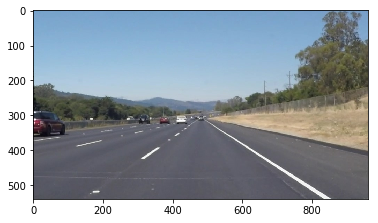

In [24]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [25]:
# from pprint import pprint
import functools
import math
from copy import copy
from collections import deque

blur_kernel_size = 5
canny_low_threshold = 20
canny_high_threshold = 80 # 50

hough_rho = 2
hough_theta = 1 * np.pi / 180
hough_threshold = 15
hough_min_line_length = 150
hough_max_line_gap = 70

line_color = (255, 0, 0)
line_thickness = 5

# roi is a trapezoid. roi_height is a fraction of the viewport's height
# and roi_top_width is a fraction of the viewport's width (the bottom is
# 100% of the width of the viewport
roi_height = 0.5
roi_top_width = 0.25

# how far up the image we want to extend the lanes
lane_height = 0.4

# for videos, how much the angle of the left/right lane line may change per frame
theta_max_interframe_delta = math.pi / 180
# for videos, how much the ymax-intercept of the left/right lane line may change per frame
ymax_intercept_max_interframe_delta = 1


def roi_mask(img):
    """
    Return a mask for the region-of-interest in `img` where lane markers may be.
    
    The ROI is a trapezoid like
    
    --------------
    |            |
    |   ------   |
    |  /      \  |
    | /        \ |
    |/          \|
    --------------
    """
    mask = np.zeros_like(img)
    
    # support both single-channel (grayscale/BW) and 3-channel (color) images
    if len(img.shape) == 2:
        color = 255
    elif len(img.shape) == 3:
        color = (255,) * img.shape[2]
    else:
        raise Exception('image did not have either 2 or 3 dimensions')
    
    ysize, xsize = img.shape[:2]

    vertices = [
        (0, ysize - 1),  # lower left
        (int(0.5 * (1 - roi_top_width) * xsize), int((1 - roi_height) * ysize)),  # upper left
        (int(0.5 * (1 + roi_top_width) * xsize), int((1 - roi_height) * ysize)),  # upper right
        (xsize - 1, ysize - 1),  # lower right
    ]
    cv2.fillPoly(mask, np.array([vertices]), color)
    
    return mask


def line_color_mask(img):
    """
    Return a mask for areas in the image that are the color of lane lines.
    
    Filters (using HSV color space) for regions that are white (saturation < 32 and value >= 224) or
    yellow (hue in range [20, 25]). Afterwards dilates the result to fill in gaps and catch border
    pixels.
    """
    mask = np.zeros_like(img)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    yellow_mask = (20 <= img_hsv[:, :, 0]) & (img_hsv[:, :, 0] <= 25)
    
    white_mask = (img_hsv[:, :, 1] < 32) & (img_hsv[:, :, 2] >= 224)  # low saturation and high value

    rv_mask = yellow_mask | white_mask
    rv_mask = rv_mask.astype('uint8') * 255
    
    rv_mask = cv2.dilate(rv_mask, np.ones([9, 9]))
    rv_mask = cv2.erode(rv_mask, np.ones([9, 9]))
    
    return rv_mask
    

class Line:
    """
    Represents a line segment on the viewport.
    """
    def __init__(self, x1, y1, x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.y2 = y2
        self.x2 = x2
        
        # normalize, so y2 is always >= y1 and theta is always >= 0
        if self.theta < 0:
            self.x1, self.x2 = self.x2, self.x1
            self.y1, self.y2 = self.y2, self.y1
        
        assert self.y2 >= self.y1
    
    @property
    def p1(self):
        return self.x1, self.y1
    
    @property
    def p2(self):
        return self.x2, self.y2
    
    @property
    def p1int(self):
        return int(self.x1), int(self.y1)
    
    @property
    def p2int(self):
        return int(self.x2), int(self.y2)

    @property
    def m(self):
        """
        Slope of line.
        
        Returns +inf if line is vertical, nan if line is degenerate (endpoints are equal).
        """
        if self.x1 == self.x2:
            if self.y1 == self.y2:
                return float('nan')
            return float('inf')
        return (self.y2 - self.y1) / (self.x2 - self.x1)
    
    @property
    def theta(self):
        """
        Rotation of line (clockwise from positive x axis) in radians.
        """
        return math.atan2(self.y2 - self.y1, self.x2 - self.x1)
    
    @property
    def thetad(self):
        """
        .theta in degrees.
        """
        return math.degrees(self.theta)
    
    def scaled_to_ymax(self, y):
        """
        Returns a new line that is extended or shortened so that the maximum y value is equal to `y`.
        """
        rv = copy(self)
        
        if self.m == 0:
            return rv  # can't do anything
        
        if self.x1 == self.x2:
            rv.y2 = y
            return rv
        
        rv.x2 += (y - self.y2) / self.m
        rv.y2 = y
        
        return rv
    
    def scaled_to_ymin(self, y):
        """
        Returns a new line that is extended or shortened so that the minimum y value is equal to `y`.
        """
        rv = copy(self)
        
        if self.m == 0:
            return rv  # can't do anything
        
        if self.x1 == self.x2:
            rv.y1 = y
            return rv
        
        rv.x1 += (y - self.y1) / self.m
        rv.y1 = y
        
        return rv
    
    @classmethod
    def from_ymaxinter_theta(cls, ymaxinter, theta, ymin, ymax):
        """
        Given a ymax-intercept and a theta, construct a line. Also needs ymin and ymax params.
        """
        return Line(
            ymaxinter - (ymax - ymin) / math.tan(theta),
            ymin,
            ymaxinter,
            ymax,
        )

    
def find_left_right_lane_markers(img):
    """
    Find the left and right lane markers in an input image.
    
    Returns (left_marker, right_marker) as Line objects, which may be None if no lane was found.
    """
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    blurred = cv2.GaussianBlur(img_gray, (blur_kernel_size, blur_kernel_size), 0)

    edges = cv2.Canny(blurred, canny_low_threshold, canny_high_threshold)
    
    edges = cv2.dilate(edges, np.ones([9, 9]))
    edges = cv2.erode(edges, np.ones([11, 11]))

    edges &= roi_mask(edges)

    edges &= line_color_mask(img)
    
    lines = cv2.HoughLinesP(edges, hough_rho, hough_theta, hough_threshold, np.array([]),
                            minLineLength=hough_min_line_length, maxLineGap=hough_max_line_gap)

    lines = lines if lines is not None else []  # HoughLinesP may return None if there are no matches

    lines = [Line(*l[0]) for l in lines]

    markers = get_left_right_lane_markers_from_lines(edges, lines)

    return markers


def get_left_right_lane_markers_from_lines(img, lines):
    """
    Given all the lines on the image, return the left and right lane markers.
    
    Returns (left_marker, right_marker) as Line objects, which may be None if no lane was found.
    """
    
    ymax = img.shape[0] - 1

    filtered = []
    for line in lines:
        # assuming the car is pointing relatively straight
        if abs(90 - line.thetad) > 70:
            continue
        filtered.append(line)
    
    # note: these conditions seem backwards but are correct because positive y direction is downwards!!
    # theta = pi/4 is a line that goes from top left to bottom right, i.e. right side lane marker
    # we're assuming that the left lane has a slope going from bottom left to top right and the right lane
    # has a slope going from top left to bottom right. That is, the road looks like / \ and not / / or \ \
    lefts = [line for line in filtered if line.thetad > 90]
    rights = [line for line in filtered if line.thetad < 90]
    lefts.sort(key=lambda l: l.theta)
    rights.sort(key=lambda l: l.theta)
    
    # just pick the lines that are closest to center
    representative_left = lefts[0] if lefts else None
    representative_right = rights[-1] if rights else None
    
    if representative_left:
        representative_left = representative_left.scaled_to_ymax(ymax).scaled_to_ymin((1 - lane_height) * ymax)
    if representative_right:
        representative_right = representative_right.scaled_to_ymax(ymax).scaled_to_ymin((1 - lane_height) * ymax)

    return representative_left, representative_right



def draw_lanes(img):
    lane_markers = filter(None, find_left_right_lane_markers(img))
    lane_img = np.zeros_like(img)
    for lane in lane_markers:
        cv2.line(lane_img, lane.p1int, lane.p2int, line_color, line_thickness)
    
    out_img = cv2.addWeighted(img, 0.8, lane_img, 1, 0)
    
    return out_img


class MultiFrameProcessor:
    # 5 extra frames in each direction
    # on each call to process_frame(), `context_frames` will be a list of 11 frames (the 5 previous
    # frames, the current frame, and the next 5 frames)
    CONTEXT_FRAMES = 5  
    
    def __init__(self, clip):
        self._clip = clip
        self._frames_iter = clip.iter_frames()
        self._frames_deque = deque()
        self._frames_deque.extend([None] * self.CONTEXT_FRAMES)
        for i in range(self.CONTEXT_FRAMES + 1):
            self._frames_deque.append(next(self._frames_iter))
        self._state = None
    
    def __call__(self, frame):
        # TODO: there is an off-by-one error where `frame` is actually equal to
        # self._frames_deque[self.CONTEXT_FRAMES - 1], whereas it should be equal to
        # self._frames_deque[self.CONTEXT_FRAMES], for all frames except the first. Perhaps
        # moviepy calls us twice for the first frame?
        out_frame, out_state = self.process_frame(
            frame,
            list(self._frames_deque),
            self._state)
        
        self._frames_deque.popleft()
        try:
            self._frames_deque.append(next(self._frames_iter))
        except StopIteration:
            self._frames_deque.append(None)
        
        self._state = out_state
        
        return out_frame
        
    @classmethod
    def apply(cls, clip):
        mfp = cls(clip)
        return clip.fl_image(mfp)
    
    @classmethod
    def process_frame(cls, in_frame, context_frames, in_state):
        """
        Returns out_frame, out_state tuple.
        """
        raise NotImplementedError


class LaneExtractor(MultiFrameProcessor):
    @classmethod
    def process_frame(cls, in_frame, context_frames, in_state):
        if not in_state:
            # if we're processing the very first frame, take the median ymax-intercept
            # and theta from the first CONTEXT_FRAMES + 1 frames
            lanes = []
            for f in context_frames[cls.CONTEXT_FRAMES:]:
                lanes.append(find_left_right_lane_markers(f))
            
            left_ymaxinter = np.median([p[0].x2 for p in lanes if p[0]])
            left_theta = np.median([p[0].theta for p in lanes if p[0]])
            right_ymaxinter = np.median([p[1].x2 for p in lanes if p[1]])
            right_theta = np.median([p[1].theta for p in lanes if p[1]])
        else:
            # otherwise, compute the ymax-intercept and theta for this frame, then take the previous
            # frame's ymax-intercept and theta and move them by up to 2 pixels and pi/180 radians,
            # respectively, towards the values computed for this frame
            prev_left_lane, prev_right_lane = in_state
            curr_left_lane, curr_right_lane = find_left_right_lane_markers(in_frame)
            
            if curr_left_lane:
                left_ymaxinter = cls.saturate_towards(prev_left_lane.x2, curr_left_lane.x2,
                                                      ymax_intercept_max_interframe_delta)
                left_theta = cls.saturate_towards(prev_left_lane.theta, curr_left_lane.theta,
                                                  theta_max_interframe_delta)
            else:
                left_ymaxinter = prev_left_lane.x2
                left_theta = prev_left_lane.theta
            
            if curr_right_lane:
                right_ymaxinter = cls.saturate_towards(prev_right_lane.x2, curr_right_lane.x2,
                                                       ymax_intercept_max_interframe_delta)
                right_theta = cls.saturate_towards(prev_right_lane.theta, curr_right_lane.theta,
                                                   theta_max_interframe_delta)
            else:
                right_ymaxinter = prev_right_lane.x2
                right_theta = prev_right_lane.theta

        ymax = in_frame.shape[0] - 1
        ymin = ymax * (1 - lane_height)
        left_lane = Line.from_ymaxinter_theta(left_ymaxinter, left_theta, ymin, ymax)
        right_lane = Line.from_ymaxinter_theta(right_ymaxinter, right_theta, ymin, ymax)
        
        out_state = left_lane, right_lane
        
        lane_img = np.zeros_like(in_frame)
        for lane in [left_lane, right_lane]:
            cv2.line(lane_img, lane.p1int, lane.p2int, line_color, line_thickness)
    
        out_frame = cv2.addWeighted(in_frame, 0.8, lane_img, 1, 0)
    
        return out_frame, out_state

    @staticmethod
    def saturate_towards(in_val, target_val, epsilon):
        if target_val < in_val:
            return max(target_val, in_val - epsilon)
        return min(target_val, in_val + epsilon)


def bw_to_rgb(img):
    if len(img.shape) == 3:
        return img
    
    rv = np.stack([img, img, img], -1)
    if rv.max() == 1:
        rv *= 255
    
    return rv


for imgname in os.listdir('test_images/'):
    img = mpimg.imread('test_images/' + imgname)
    
    # debug
    out_img = find_left_right_lane_markers(img)
    if not isinstance(out_img, np.ndarray):
        # prod
        out_img = draw_lanes(img)
    
    out_img = bw_to_rgb(out_img)

    out_img = cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR)
    
    cv2.imwrite('test_images_output/' + imgname, out_img)
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [26]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [27]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    return draw_lanes(image)

Let's try the one with the solid white lane on the right first ...

In [28]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
#white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip = LaneExtractor.apply(clip1)
%time white_clip.write_videofile(white_output, audio=False, write_logfile=True, verbose=True)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



 70%|██████▉   | 155/222 [00:36<00:18,  3.71it/s]


100%|█████████▉| 221/222 [00:48<00:00,  4.57it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 7.28 s, sys: 3.7 s, total: 11 s
Wall time: 49.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [30]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
#yellow_clip = clip2.fl_image(process_image)
yellow_clip = LaneExtractor.apply(clip2)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



 23%|██▎       | 155/682 [00:26<01:27,  6.01it/s]


 45%|████▌     | 309/682 [00:53<01:04,  5.81it/s]


 68%|██████▊   | 463/682 [01:21<00:39,  5.59it/s]


 90%|█████████ | 617/682 [01:50<00:17,  3.70it/s]


100%|█████████▉| 681/682 [02:00<00:00,  9.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 20.5 s, sys: 9.62 s, total: 30.1 s
Wall time: 2min 1s


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [32]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
## clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
#challenge_clip = clip3.fl_image(process_image)
challenge_clip = LaneExtractor.apply(clip3)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



 62%|██████▏   | 155/251 [01:07<00:58,  1.65it/s]


100%|██████████| 251/251 [01:46<00:00,  2.35it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 15.4 s, sys: 5.74 s, total: 21.2 s
Wall time: 1min 48s


In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))